# 导入包

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

# 创建模型

In [15]:
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.fc_layer = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layer(x)
        return x
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader): # 每次读入一个batch的数据，使用enumerate可以得到batch下标
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch:{} [{} / {} ({:.0f}%)]\t Loss:{:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), # len(train_loader.dataset)表示整个训练集的长度（多少个实例）
                100. * batch_idx / len(train_loader), loss.item())) # len(train_loader)表示一共分了多少个batch

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader: # 每次读入一个batch数据，无下标
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))

# 加载数据集，并训练

In [3]:
train_data = datasets.MNIST('./datasets', train=True, download=True,
                            transform = transforms.Compose([transforms.ToTensor()]))

test_data = datasets.MNIST('./datasets', train=False, download=True,
                           transform = transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [16]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch:1 [0 / 60000 (0%)]	 Loss:2.322060
Train Epoch:1 [12800 / 60000 (21%)]	 Loss:2.285474
Train Epoch:1 [25600 / 60000 (43%)]	 Loss:2.145182
Train Epoch:1 [38400 / 60000 (64%)]	 Loss:1.155446
Train Epoch:1 [51200 / 60000 (85%)]	 Loss:0.981019

Test set: Average loss: 0.0055, Accuracy: 8647/10000 (86%)

Train Epoch:2 [0 / 60000 (0%)]	 Loss:0.926167
Train Epoch:2 [12800 / 60000 (21%)]	 Loss:0.685179
Train Epoch:2 [25600 / 60000 (43%)]	 Loss:0.616786
Train Epoch:2 [38400 / 60000 (64%)]	 Loss:0.558117
Train Epoch:2 [51200 / 60000 (85%)]	 Loss:0.492424

Test set: Average loss: 0.0029, Accuracy: 9221/10000 (92%)



# SHAP

In [17]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [18]:
# np.swapaxes根据多维数组维度下标交换数据维度
# 第一个参数指多维数组
# 后两个参数指维度下标
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

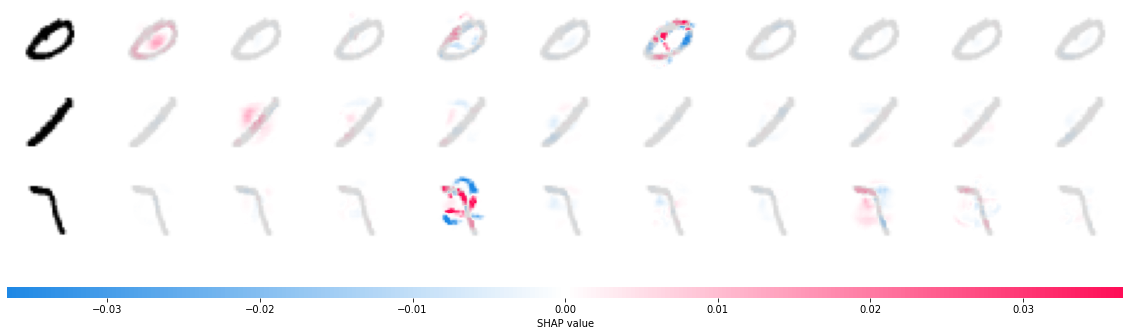

In [19]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)